# papers

> This notebook details a ML pipeline built for the [Faster R-CNN](https://towardsdatascience.com/faster-rcnn-object-detection-f865e5ed7fc4) architecture trained on a custom dataset of pdf documents.


- toc: true
- badges: true
- comments: false
- categories: [jupyter]








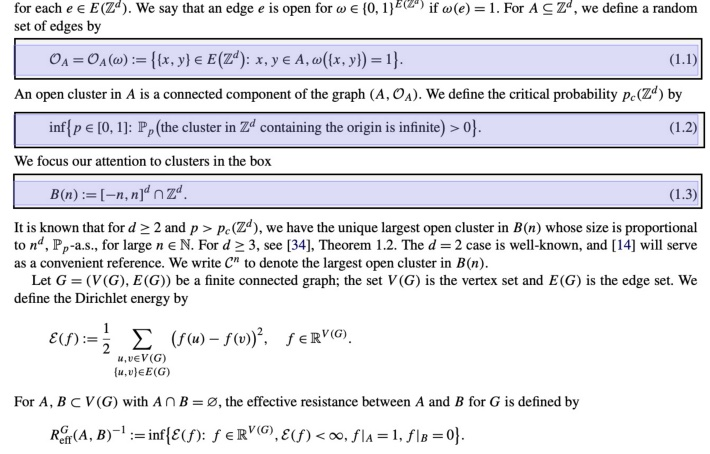

$\quad$ This notebook details a machine learning pipeline built for a custom dataset. I assembled the dataset from a collection of pdfs, a corpus of scientific documents. Feeding the data into a PyTorch implementation of the [Faster R-CNN](https://towardsdatascience.com/faster-rcnn-object-detection-f865e5ed7fc4) architecture, I trained the network to draw bounding boxes around labeled equations, those which are referenced throughout the paper. I see this as a small first step towards a more intricate object detection tool for extracting the logical structure of a math paper (to begin with) given its input as a pdf.

## training metrics for latest trained model

( `model_weights_7_50e_lightning` )

In either case below, the $x$-axis corresponds to time elapsed in minutes, not epochs. There is no smoothing applied.

_validation AP 1_

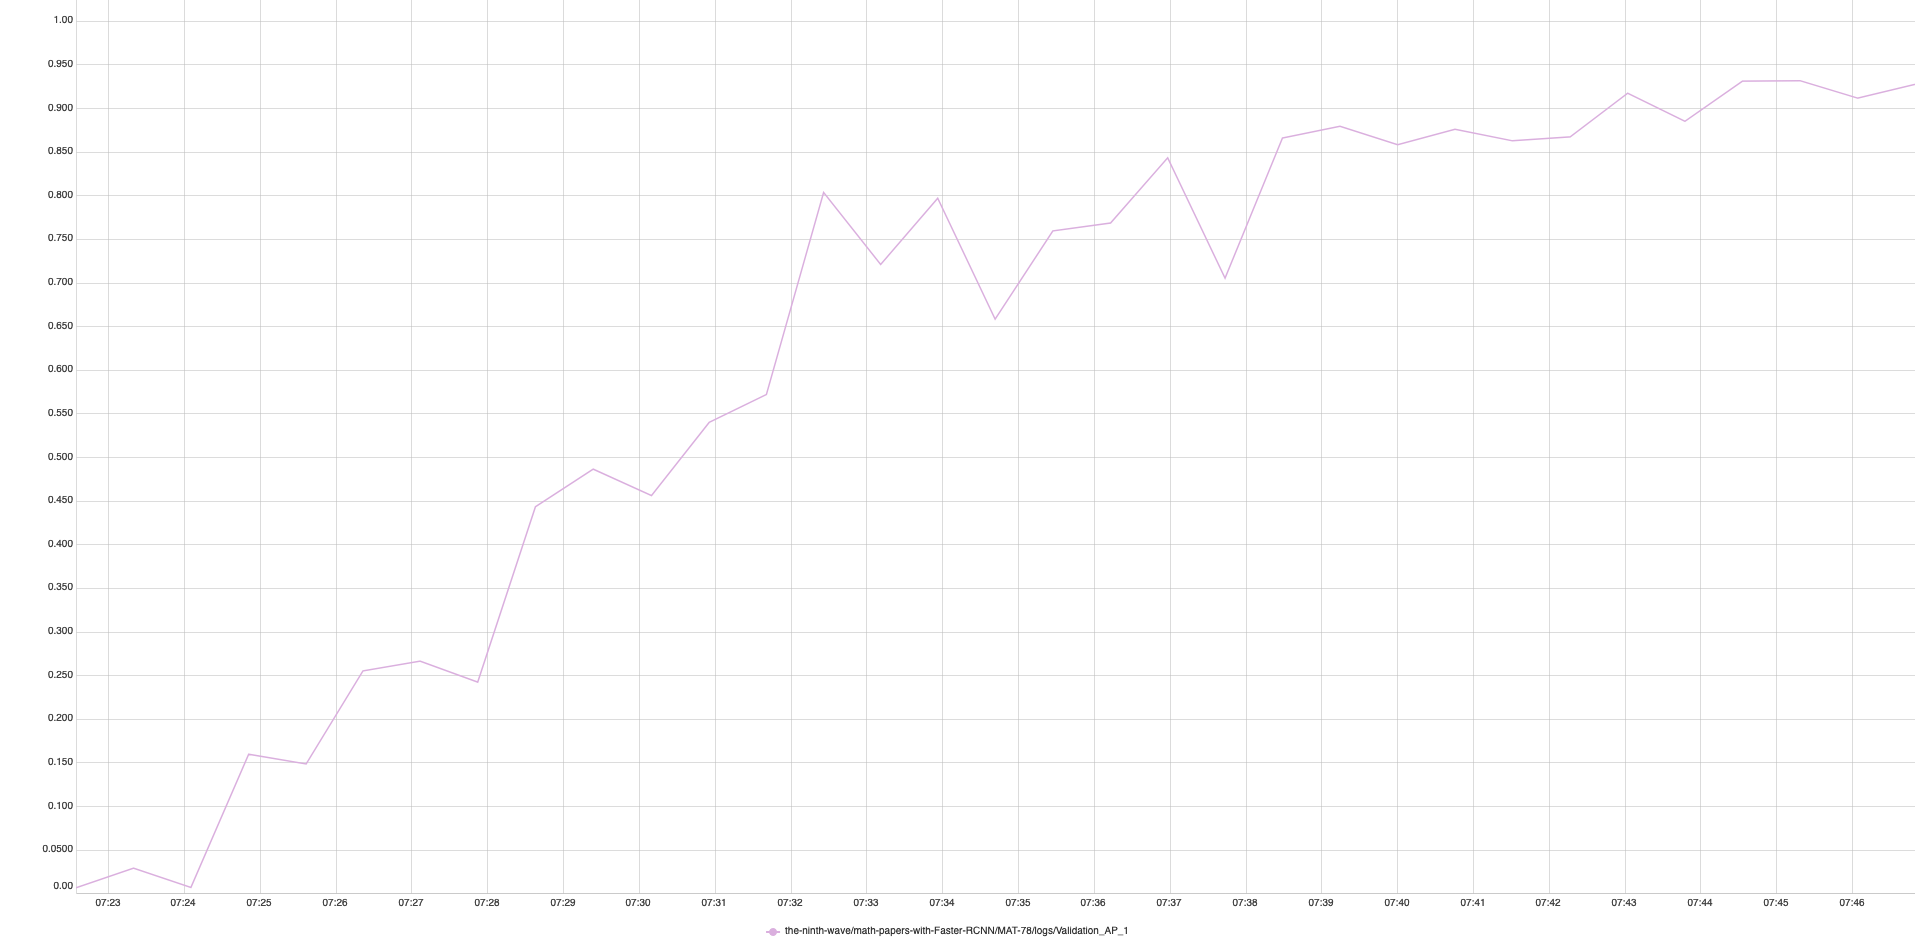

_validation mAP_

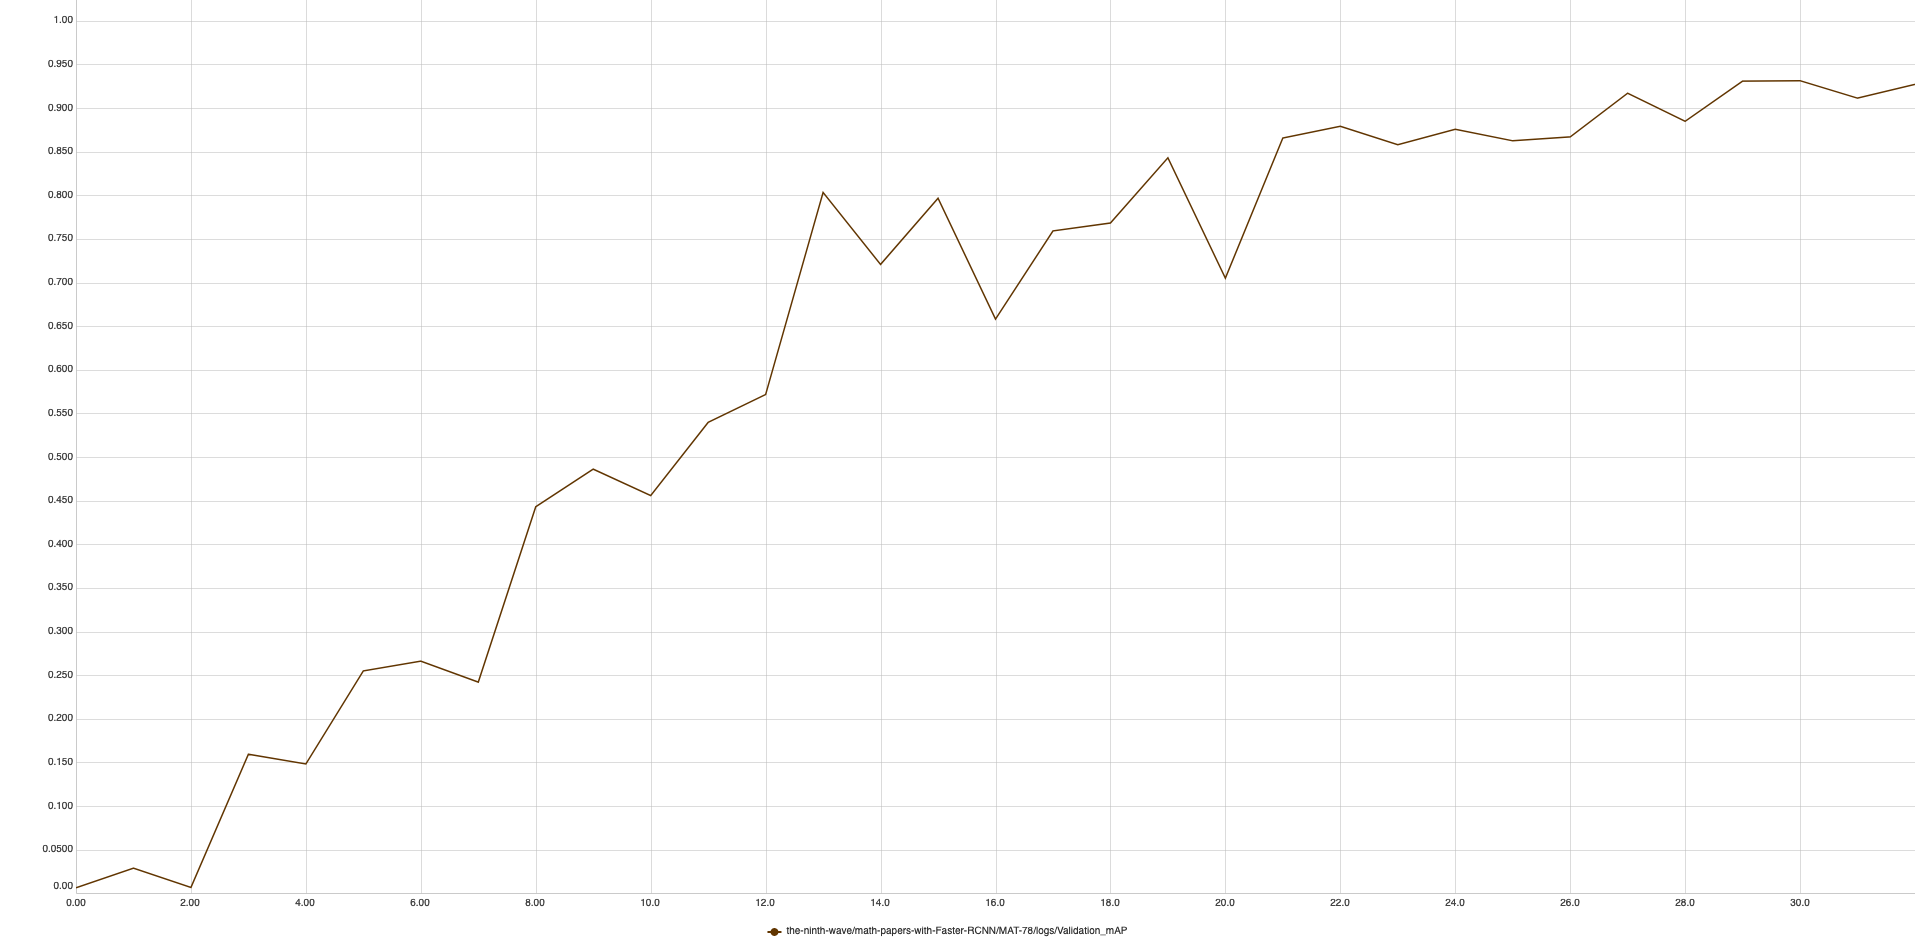

## setup

_pip installs_

In [ ]:
!pip3 install --quiet "seaborn"

In [ ]:
!pip3 install --quiet --upgrade "pytorch-lightning"

     |████████████████████████████████| 925 kB 12.8 MB/s 
     |████████████████████████████████| 596 kB 78.1 MB/s 
     |████████████████████████████████| 282 kB 96.6 MB/s 
     |████████████████████████████████| 125 kB 96.4 MB/s 
     |████████████████████████████████| 829 kB 86.0 MB/s 
     |████████████████████████████████| 1.3 MB 72.2 MB/s 
     |████████████████████████████████| 160 kB 85.6 MB/s 
     |████████████████████████████████| 271 kB 88.7 MB/s 


In [ ]:
!pip3 install --quiet "torchmetrics>=0.3" "torchvision"

In [ ]:
!pip3 install --quiet PyQt5

     |████████████████████████████████| 8.3 MB 11.5 MB/s 
     |████████████████████████████████| 317 kB 87.8 MB/s 
     |████████████████████████████████| 59.9 MB 69 kB/s 


In [ ]:
!pip3 install --quiet neptune-contrib

     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 278 kB 30.4 MB/s 
     |████████████████████████████████| 52 kB 1.7 MB/s 
     |████████████████████████████████| 180 kB 89.0 MB/s 
     |████████████████████████████████| 131 kB 83.7 MB/s 
     |████████████████████████████████| 8.0 MB 81.7 MB/s 
     |████████████████████████████████| 79 kB 10.4 MB/s 
     |████████████████████████████████| 138 kB 96.9 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 127 kB 96.6 MB/s 
     |████████████████████████████████| 67 kB 7.2 MB/s 
     |████████████████████████████████| 129 kB 92.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip3 install --quiet --upgrade albumentations

     |████████████████████████████████| 102 kB 15.3 MB/s 
     |████████████████████████████████| 47.6 MB 36 kB/s 


_imports_

In [ ]:
#collapse-hide

import os
import sys
import xml.etree.ElementTree as ET
import re
import time

import itertools
import logging
import json
from collections import OrderedDict

import random
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.metrics.functional import accuracy

import seaborn as sns
import tabulate

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms

from IPython.display import HTML, display, set_matplotlib_formats
from PIL import Image, ImageDraw
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import cv2
import matplotlib.pyplot as plt
set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()
%matplotlib inline

_global parameters, paths_

In [ ]:
#collapse-hide

AVAIL_GPUS = min(1, torch.cuda.device_count())

PDF_PATH = "drive/Othercomputers/Normandie/GitHub/home/datasets/percolation_papers_2/data/papers/pdf"
DATASET_DIR = "drive/Othercomputers/Normandie/GitHub/home/datasets/percolation_papers_2/data/papers"
DATASET_DIR_DIR = "drive/Othercomputers/Normandie/GitHub/home/datasets/percolation_papers_2/data"

## paper collection, paper, and page objects

pre-`torch`, data is organized in three python classes,  `paper_collection_object`,  `paper_object` `page_object`. We can instantiate a `paper_collection` object given a list of paper names, along with an implicit path to the data. 

___

### class ... `paper_collection_object`

_args of `__init__`_

* `list_of_filenames`

|      attributes        |           |            |   |   |
|--------------|-----------|------------|-----|----|
| `paper_list` | `pdf_list`      | `num_papers` | `pages_path` |
|  `labels_path`     | `pages`  | `labels`      | `binary_txt_path` |
| `non_empt_indices` | `total_pages` | `paper_ranges` | 



In [ ]:
#collapse-hide

import pandas as pd

class paper_collection_object():

    def __init__(self, list_of_filenames ):

        self.paper_list = list_of_filenames # without suffixes

        self.pdf_list = [ filename + '.pdf' for filename in self.paper_list ]

        self.num_papers = len( list_of_filenames )

        self.pages_path = DATASET_DIR + '/' + 'jpg_pages'

        self.labels_path = DATASET_DIR + '/' + 'labels_xml'

        self.pages = list(sorted(os.listdir(self.pages_path)))

        self.labels = list(sorted(os.listdir(self.labels_path)))

        self.binary_txt_path = DATASET_DIR_DIR + '/' + 'empty_0_box_1.txt'

        self.non_empt_indices = self.get_non_empt_indices()

        self.total_pages = len(self.pages)

        self.paper_ranges = self.get_paper_ranges()


    def get_non_empt_indices(self):

        with open(self.binary_txt_path, "r") as tf:
            indicator_list = tf.read().split('\n')

        non_empt_indices = []

        for i in range(len(indicator_list)):
            if indicator_list[i] == '1':
                non_empt_indices.append(i)
        
        return non_empt_indices

    def get_paper_range(self, paper):
        # paper is a string
        paper_indices = []

        N = self.total_pages

        for j in range(N):
            if paper in self.pages[j]:
                paper_indices.append(j)
            else:
                pass
        
        return [ paper_indices[0], paper_indices[-1] ]


    def get_paper_ranges(self):
        
        paper_ranges = []

        for paper in self.paper_list:
            paper_ranges.append( self.get_paper_range(paper) )

        return paper_ranges

    def display_info(self):

        pdf_dir_ls = list(sorted(os.listdir(PDF_PATH)))
        list_of_filenames = [ a.split(".")[0] for a in pdf_dir_ls ]
        filenames_df = pd.DataFrame( list_of_filenames, columns=['papers'] )
        print( filenames_df )


|      class methods        |           |            |
|--------------|-----------|------------|
| `get_non_empt_indices( self )` | `get_paper_range( self, paper )`      |
| `get_paper_ranges( self )`        | `display_info( self )` |

___







We define three key lists in the cells hidden below.

|     key lists         |           |            |
|--------------|-----------|------------|
| `PAPER_LIST`| `INDICES`      | `PAGE_LIST` |

This is what the `display_info` method looks like on the dataset in question. To call it, we introduce the `PAPER_LIST` used to initialize dataset.

In [ ]:
#collapse-hide

pdf_dir_ls = list(sorted(os.listdir(PDF_PATH)))
PAPER_LIST = [ a.split(".")[0] for a in pdf_dir_ls ]

collection = paper_collection_object( PAPER_LIST )
collection.display_info()

                         papers
0            abe_2015_effective
1           aizenman_1983_sharp
2      aizenman_1987_uniqueness
3          aizenman_1998_holder
4           antal_1996_chemical
5           atapour_2010_number
6          beaton_2018_knotting
7       bonato_2020_asymptotics
8    broadbent_1956_percolation
9       campanino_2002_ornstein
10  caraglio_2020_translocation
11              cerf_2015_lower
12                cerf_2018_new
13  coward_2007_algorithmically
14           duminil_2020_upper
15             even_2017_models
16  grimmett_1990_supercritical
17      grimmett_1999_conformal
18   grimmett_1999_entanglement
19   grimmett_1999_inequalities
20     grimmett_2010_plaquettes
21    grimmett_2013_percolation
22    haggstrom_1999_uniqueness
23       holroyd_1997_existence
24       holroyd_1999_existence
25    holroyd_2001_entanglement
26    holroyd_2001_inequalities
27      holroyd_2012_stochastic
28         ishihara_2017_bounds
29      kantor_1988_topological
30      

For later initializing the dataset, we record the indices of "non-empty" pages in the full page list in `INDICES`.

In [ ]:
#collapse-hide

INDICES = collection.non_empt_indices
print(INDICES)

[1, 2, 4, 5, 6, 7, 10, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 67, 68, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 120, 121, 122, 123, 124, 125, 127, 128, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 149, 150, 151, 159, 161, 169, 170, 174, 175, 176, 177, 178, 179, 182, 183, 184, 185, 186, 188, 189, 190, 200, 201, 202, 203, 205, 206, 207, 208, 213, 214, 226, 233, 234, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 254, 255, 256, 257, 258, 259, 260, 261, 319, 320, 321, 322, 326, 331, 332, 333, 334, 337, 340, 341, 342, 347, 348, 349, 350, 352, 353, 401, 406, 407, 408, 409, 411, 414, 449, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 465, 466, 470, 471, 474, 49

Through these indices, we can name specific pages that correspond to these indices. This is `PAGE_LIST`.

In [ ]:
#collapse-hide

PAGE_LIST = collection.pages
print(PAGE_LIST)

['abe_2015_effective_0001', 'abe_2015_effective_0002', 'abe_2015_effective_0003', 'abe_2015_effective_0004', 'abe_2015_effective_0005', 'abe_2015_effective_0006', 'abe_2015_effective_0007', 'abe_2015_effective_0008', 'abe_2015_effective_0009', 'abe_2015_effective_0010', 'abe_2015_effective_0011', 'abe_2015_effective_0012', 'aizenman_1983_sharp_0001', 'aizenman_1983_sharp_0002', 'aizenman_1983_sharp_0003', 'aizenman_1983_sharp_0004', 'aizenman_1983_sharp_0005', 'aizenman_1983_sharp_0006', 'aizenman_1983_sharp_0007', 'aizenman_1983_sharp_0008', 'aizenman_1983_sharp_0009', 'aizenman_1983_sharp_0010', 'aizenman_1983_sharp_0011', 'aizenman_1983_sharp_0012', 'aizenman_1983_sharp_0013', 'aizenman_1983_sharp_0014', 'aizenman_1983_sharp_0015', 'aizenman_1983_sharp_0016', 'aizenman_1983_sharp_0017', 'aizenman_1983_sharp_0018', 'aizenman_1983_sharp_0019', 'aizenman_1983_sharp_0020', 'aizenman_1983_sharp_0021', 'aizenman_1983_sharp_0022', 'aizenman_1983_sharp_0023', 'aizenman_1983_sharp_0024', 'ai

___

### class ... `paper_object`

_args of `__init__`_

* `paper_collection`

* `filename`

|     attributes         |           |            |   |   |
|--------------|-----------|------------|-----|----|
| `name` | `parent_collection`      | `pdf_path`      |  `num_pages`      | 
|`names_of_pages`  | `names_of_jpgs`       | `names_of_xmls` | 
| `global_pdf_index` | `global_index_range` | `non_empty_list` | 



In [ ]:
#collapse-hide

class paper_object( ):

    def __init__(self, paper_collection, filename):

        self.name = filename

        self.parent_collection = paper_collection

        self.global_pdf_index = self.get_global_pdf_index()

        self.pdf_path = PDF_PATH + '/' + filename + '.pdf'

        self.global_index_range = self.get_global_index_range()

        self.num_pages = self.global_index_range[1] - self.global_index_range[0] + 1

        self.names_of_pages = self.list_page_names()

        self.names_of_jpgs = [ page_name + '.jpg' for page_name in self.names_of_pages ]

        self.names_of_xmls = [ page_name + '.xml' for page_name in self.names_of_pages ]

        self.non_empty_list = self.get_non_empty_list()

    def zpad_string(self, s, zpadding):
        s_z = s.zfill(zpadding)
        return s_z

    def get_txt_list(self):
        path = self.txt_path
        f = open(path, "r")
        txt_list = f.readlines()
        f.close()
        return(txt_list)

    def get_num_pages(self):
        return len(self.names_of_pages)

    def list_page_names(self):
        a = self.global_index_range[0]
        b = self.global_index_range[1]

        global_index_set = range(a, b+1)

        names_list = []
        for j in global_index_set:
            page_name = self.parent_collection.pages[j]
            names_list.append( page_name )
        
        return names_list

    def get_global_pdf_index(self):
        
        collection = self.parent_collection

        collection_papers = collection.paper_list

        L = len(collection_papers)

        for j in range(L):
            if collection_papers[j] == self.name:
                index = j
        
        return(index)

    def get_global_index_range(self):

        collection = self.parent_collection

        global_pdf_index = self.global_pdf_index

        collection_ranges = collection.paper_ranges

        index_range = collection_ranges[ self.global_pdf_index ]

        return(index_range)

    def get_non_empty_list(self):

        index_range = self.global_index_range

        a = index_range[0]

        b = index_range[1]

        collection = self.parent_collection

        all_non_empt_indices = collection.non_empt_indices

        paper_non_empt = [ j for j in all_non_empt_indices if (j >= a) and (j <= b) ]

        return paper_non_empt 

|    class methods          |           |            |
|--------------|-----------|------------|
| `get_txt_list( self )` | `get_num_pages( self )`      | `list_page_names( self )`      |
| `get_margin_boxes( self, hires )`      | `get_global_pdf_index( self )` | `get_global_index_range( self )`       |
| `get_non_empty_list( self )` | `zpad_string( s, zpadding )` |

___

___

### class ... `page_object`

_args of `__init__`_

* `paper`

* `page_number`

|       attributes       |           |            |   |   |
|--------------|-----------|------------|-----|----|
| `parent_paper` | `grandparent_collection`      | `number`        | `jpg_name` | `xml_name` | 
| `jpg_path`      | `xml_path`  |  `non_empty` |



In [ ]:
#collapse-hide

from PIL import Image

class page_object():

    def __init__(self, paper, page_number):

        self.parent_paper = paper

        self.grandparent_collection = self.parent_paper.parent_collection 

        self.number = page_number

        self.jpg_name = self.parent_paper.names_of_pages[ self.number - 1 ]

        self.xml_name = self.parent_paper.names_of_xmls[ self.number - 1 ]

        self.jpg_path = DATASET_DIR + '/' + 'jpg_pages' + '/' + self.jpg_name

        self.xml_path = DATASET_DIR + '/' + 'labels_xml' + '/' + self.xml_name

        self.non_empty = self.get_non_empty_status()

    def get_non_empty_status(self):
        
        paper = self.parent_paper

        paper_global_index_range = paper.global_index_range

        a = paper_global_index_range[0]

        global_index = a + self.number - 1

        if global_index in paper.non_empty_list:
            return True
        else:
            return False

    def get_RGB(self):

        page = Image.open(self.jpg_path).convert("RGB")

        trans = transforms.Compose([transforms.ToTensor()])

        page_tens = trans(page)

        #print( page_tens.size() )

        #page_pil = Image.fromarray(np.array()).convert("RGB")

        return page

    def get_target(self):

        xml_path = self.xml_path

        xml = ET.parse(xml_path)

        xml_root = xml.getroot()

        is_empty = xml_root.tag == 'empty'

        boxes = []

        labels = []

        iscrowd = []

        area = []

        if is_empty:
            # prep boxes, masks, labels
            boxes_tens = torch.as_tensor(boxes, dtype=torch.float32)
            boxes_tens = boxes_tens[:,None]
            labels = torch.as_tensor(labels, dtype = torch.int64)
            iscrowd = torch.as_tensor(iscrowd, dtype = torch.int64)
            area = torch.as_tensor(area, dtype= torch.float32)

        else:
            # prep boxes
            xmin_Elements = xml_root.findall("./object/bndbox/xmin")
            xmin = [ np.float(j.text) for j in xmin_Elements ]
            ymin_Elements = xml_root.findall("./object/bndbox/ymin")
            ymin = [ np.float(j.text) for j in ymin_Elements ]
            xmax_Elements = xml_root.findall("./object/bndbox/xmax")
            xmax = [ np.float(j.text) for j in xmax_Elements ]
            ymax_Elements = xml_root.findall("./object/bndbox/ymax")
            ymax = [ np.float(j.text) for j in ymax_Elements ]

            # The following are heights and widths
            h = torch.as_tensor(ymax) - torch.as_tensor(ymin)
            w = torch.as_tensor(xmax) - torch.as_tensor(xmin)
            
            # load labels
            labels = torch.ones( (len(xmin),), dtype = torch.int64)
            iscrowd = torch.zeros( (len(xmin),), dtype = torch.int64)
            
            ## load boxes and recast
            for j in range(0,len(xmin)):
                box = [ xmin[j], ymin[j], xmax[j], ymax[j] ]
                boxes.append(box)
                area.append( w[j]* h[j] )
            
            #boxes_stack= torch.stack(boxes, dim=0)
            boxes_tens = torch.as_tensor(boxes, dtype=torch.float32)
            area = torch.as_tensor(area, dtype=torch.float32)
        
        # target
        target = {}
        target["boxes"] = boxes_tens
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        return target

|     class methods         |           |            |
|--------------|-----------|------------|
| `get_non_empty_status( self )` | `get_RGB( self )`      | `get_target( self )`    |


___

## model

___

### method ... `get_fasterRCNN`

|          args    |           |            |   |   |
|--------------|-----------|------------|-----|----|
| `num_classes`|

In [ ]:
#collapse-hide

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_fasterRCNN(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor( in_features, 
                                                      num_classes )

    return model

___

In [ ]:
model = get_fasterRCNN(2)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

## transform helpers, torchvision imports

In [ ]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ..

Cloning into 'vision'...
remote: Enumerating objects: 44087, done.
remote: Counting objects: 100% (9561/9561), done.
remote: Compressing objects: 100% (2427/2427), done.
remote: Total 44087 (delta 7442), reused 8798 (delta 6957), pack-reused 34526
Receiving objects: 100% (44087/44087), 72.31 MiB | 27.34 MiB/s, done.
Resolving deltas: 100% (33986/33986), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
import utils
import albumentations as A

from [here](https://github.com/johschmidt42/PyTorch-Object-Detection-Faster-RCNN-Tutorial/blob/master/pytorch_faster_rcnn_tutorial/transformations.py)

___
### class ... `Compose`

In [ ]:
#collapse-hide

class Compose:
    """Baseclass - composes several transforms together."""

    def __init__(self, transforms):
        self.transforms = transforms

    def __repr__(self):
        return str([transform for transform in self.transforms])


___

___

### class ... `Repr` 

In [ ]:
#collapse-hide

class Repr:
    """Evaluatable string representation of an object"""

    def __repr__(self):
        return f"{self.__class__.__name__}: {self.__dict__}"


___

___

### class ... `ComposeDouble`

In [ ]:
#collapse-hide

class ComposeDouble(Compose):
    """Composes transforms for input-target pairs."""

    def __call__(self, inp: np.ndarray, target: dict):
        for t in self.transforms:
            inp, target = t(inp, target)
        return inp, target

___

___

### class ... `AlbumentationWrapper`

In [ ]:
#collapse-hide

class AlbumentationWrapper(Repr):
    """
    A wrapper for the albumentation package.
    Bounding boxes are expected to be in xyxy format (pascal_voc).
    Bounding boxes cannot be larger than the spatial image's dimensions.
    Use Clip() if your bounding boxes are outside of the image, before using this wrapper.
    """

    def __init__(self, albumentation, format: str = "pascal_voc"):
        self.albumentation = albumentation
        self.format = format

    def __call__(self, inp: np.ndarray, tar: dict):
        # input, target
        transform = A.Compose(
            [self.albumentation],
            bbox_params=A.BboxParams(format=self.format, label_fields=["class_labels"]),
        )

        out_dict = transform(image=inp, bboxes=tar["boxes"], class_labels=tar["labels"])

        input_out = np.array(out_dict["image"])
        boxes = np.array(out_dict["bboxes"])
        labels = np.array(out_dict["class_labels"])

        tar["boxes"] = boxes
        tar["labels"] = labels

        return input_out, tar

___

____

### class ... `FunctionWrapperDouble`

In [ ]:
#collapse-hide

class FunctionWrapperDouble(Repr):
    """A function wrapper that returns a partial for an input-target pair."""

    def __init__(
        self,
        function,
        input: bool = True,
        target: bool = False,
        *args,
        **kwargs,
    ):
        self.function = partial(function, *args, **kwargs)
        self.input = input
        self.target = target

    def __call__(self, inp: np.ndarray, tar: dict):
        if self.input:
            inp = self.function(inp)
        if self.target:
            tar = self.function(tar)
        return inp, tar

## data transforms

In [ ]:
#collapse-hide

from functools import partial

transforms_training = ComposeDouble(
    [
        AlbumentationWrapper(albumentation=A.SmallestMaxSize(max_size=512)),
        FunctionWrapperDouble(np.moveaxis, source=-1, destination=0),
    ]
)

transforms_validation = ComposeDouble(
    [
        AlbumentationWrapper(albumentation=A.SmallestMaxSize(max_size=1024)),
        FunctionWrapperDouble(np.moveaxis, source=-1, destination=0),
    ]
)

transforms_test = ComposeDouble(
    [
        AlbumentationWrapper(albumentation=A.SmallestMaxSize(max_size=1024)),
        FunctionWrapperDouble(np.moveaxis, source=-1, destination=0),
    ]
)

## torch dataset class

___

### class ... `ObjectDetectionDataSet`

_`__init__` args_

* `paper_list`
        
* `transform`


In [ ]:
#collapse-hide

class ObjectDetectionDataSet(torch.utils.data.Dataset):

    def __init__(self, 
                 paper_list, 
                 transform: ComposeDouble = None):

        self.root = DATASET_DIR

        self.transform = transform

        self.collection_object = paper_collection_object( paper_list )

        self.paper_object_list = [ paper_object( self.collection_object, paper_name ) for paper_name in self.collection_object.paper_list ]

        self.page_object_list = self.get_page_object_list()

    def __getitem__(self, index):

        page_obj = self.page_object_list[index]

        page_name = page_obj.jpg_name

        target_name = page_obj.xml_name

        page = page_obj.get_RGB()

        target = page_obj.get_target()

        image_id = torch.tensor([ index ])

        target["image_id"] = image_id

        target = {
            key: value.numpy() for key, value in target.items()
        }

        if self.transform == None:
            trans = []
            
            resize = A.SmallestMaxSize(
                max_size = 1024,
                interpolation = 1
            )
            trans.append( resize )
            action = A.Compose(trans)
            page, target = action(image = np.array(page), target = target)  

        page = torch.from_numpy(np.array(page)).type(torch.float32)
        target = {
            key: torch.from_numpy(value).type(torch.int64)
            for key, value in target.items()
        }

        page_tens_permuted_1 = page.permute(0,1,2)

        page_tens_permuted_2 = page.permute(0,2,1)

        page_tens_permuted_3 = page.permute(1,0,2)

        page_tens_permuted_4 = page.permute(1,2,0)

        page_tens_permuted_5 = page.permute(2,0,1)

        page_tens_permuted_6 = page.permute(2,1,0)

        """
        print(
            " permutations in __getitem__ ", "\n",
            page_tens_permuted_1.size(), " : ", "(1)", "\n", 
            page_tens_permuted_2.size(), " : ", "(2)", "\n", 
            page_tens_permuted_3.size(), " : ", "(3)", "\n", 
            page_tens_permuted_4.size(), " : ", "(4)", "\n", 
            page_tens_permuted_5.size(), " : ", "(5)", "\n", 
            page_tens_permuted_6.size(), " : ", "(6)", "\n"
        )

        print("\n\n")
        """

        return (page_tens_permuted_5, target, page_name, target_name)

    def __len__(self):
        return(len(self.page_object_list))
        
    def make_page_objects_for_paper(self, paper):

        num_pages = paper.num_pages

        page_object_list = []

        for j in range( num_pages ):
            page_object_list.append( page_object( paper, j+1 ) )

        return page_object_list

        
    def get_page_object_list(self):

        paper_list = self.paper_object_list

        page_object_list = []

        for paper in paper_list:

            page_objects_for_paper = self.make_page_objects_for_paper( paper )

            page_object_list += page_objects_for_paper

        return page_object_list


___


## define and load datasets

(starting from a list of non-empty pages)



We do an $80$-$10$-$10$ percentage split of the data, to be fed into three datasets:

* `dataset_train`

* `dataset_val`

* `dataset_test`

There are 

In [ ]:
#collapse-hide

print(len(INDICES))

381


such non-empty pages. The above percentages are approximated by the split $305$-$38$-$38$

The training dataset will be obtained from `INDICES` by taking a random subset of these indices of size $305$. 

In [ ]:
#collapse-hide

TRAIN_INDICES = random.sample(INDICES, 305)

val_and_test_INDICES = list( set(INDICES) - set(TRAIN_INDICES) )

VAL_INDICES = random.sample(val_and_test_INDICES, 38)

TEST_INDICES = list( set(val_and_test_INDICES) - set(VAL_INDICES))

The index sets `TRAIN_INDICES`, `VAL_INDICES`, `TEST_INDICES` each give rise to corresponding sets of paper names, when their entries are used as arguments to `PAPER_LIST`. These are `TRAIN_PAPERS`, `VAL_PAPERS` and `TEST_PAPERS` defined just below.

In [ ]:
#collapse-hide

TRAIN_PAPERS = [ PAGE_LIST[j] for j in TRAIN_INDICES ]
VAL_PAPERS = [ PAGE_LIST[j] for j in VAL_INDICES ]
TEST_PAPERS = [ PAGE_LIST[j] for j in TEST_INDICES ]

_define datasets_

In [ ]:
#collapse-hide

dataset_train = ObjectDetectionDataSet(TRAIN_PAPERS, 
                                       transform = True )

dataset_valid = ObjectDetectionDataSet(VAL_PAPERS,
                                     transform = True )

dataset_test = ObjectDetectionDataSet(TEST_PAPERS,
                                      transform = True )


___
___
___

_dataset full_

In [ ]:
#collapse-hide

dataset_full = ObjectDetectionDataSet([ PAGE_LIST[j] for j in INDICES ],
                                      transform = True )

_dataloaders_: `dataloader_train`, `dataloader_valid`, `dataloader_test`

In [ ]:
#collapse-hide

from torch.utils.data import DataLoader

dataloader_train = DataLoader(
    dataset = dataset_train,
    batch_size = 2,
    shuffle = True,
    num_workers = 4,
    collate_fn = utils.collate_fn,
)

dataloader_valid = DataLoader(
    dataset = dataset_valid,
    batch_size = 2,
    shuffle = False,
    num_workers = 4,
    collate_fn = utils.collate_fn,
)

dataloader_test = DataLoader(
    dataset = dataset_test,
    batch_size = 2,
    shuffle = False,
    num_workers = 4,
    collate_fn = utils.collate_fn,
)

In [ ]:
#collapse-hide

dataloader_full = DataLoader(
    dataset = dataset_full,
    batch_size = 1,
    shuffle = False,
    num_workers = 0,
    collate_fn = utils.collate_fn,
)

## hyperparameters, logging


In [ ]:
#collapse-hide

params = {
    "AUTHOR": "the-ninth-wave",  # 
    "SAVE_DIR": None, 
    "CLASSES": 2,
    "SEED": 42,
    "PROJECT": "math-papers-with-Faster-RCNN",
    "EXPERIMENT": "math-papers-with-Faster-RCNN-EX-3",
    "MAXEPOCHS": 50, 
}

    !pip install livelossplot --quiet

    from livelossplot import PlotLosses
    liveloss = PlotLosses()
    ll_train_dict = {}
    ll_val_dict = {}
    ll_test_dict = {}

## metrics

In [ ]:
!git clone https://github.com/johschmidt42/PyTorch-Object-Detection-Faster-RCNN-Tutorial.git

Cloning into 'PyTorch-Object-Detection-Faster-RCNN-Tutorial'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (265/265), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 265 (delta 123), reused 224 (delta 82), pack-reused 0
Receiving objects: 100% (265/265), 3.74 MiB | 1.03 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [ ]:
ls

coco_eval.py   __pycache__/                                    utils.py
coco_utils.py  PyTorch-Object-Detection-Faster-RCNN-Tutorial/  vision/
drive/         sample_data/
engine.py      transforms.py


In [ ]:
cd PyTorch-Object-Detection-Faster-RCNN-Tutorial/

/content/PyTorch-Object-Detection-Faster-RCNN-Tutorial


In [ ]:
ls

anchor_script.ipynb               README.md
annotation_script.ipynb           rename_files_script.ipynb
dataset_exploration_script.ipynb  setup.py
inference_script.ipynb            training_script.ipynb
pytorch_faster_rcnn_tutorial/     training_script.py


In [ ]:
import pytorch_faster_rcnn_tutorial

from pytorch_faster_rcnn_tutorial.metrics.enumerators import MethodAveragePrecision
from pytorch_faster_rcnn_tutorial.metrics.pascal_voc_evaluator import get_pascalvoc_metrics

from pytorch_faster_rcnn_tutorial.utils import from_dict_to_boundingbox

In [ ]:
cd ..

/content


In [ ]:
ls

coco_eval.py   __pycache__/                                    utils.py
coco_utils.py  PyTorch-Object-Detection-Faster-RCNN-Tutorial/  vision/
drive/         sample_data/
engine.py      transforms.py


## lightning module

___

### class ... `FasterRCNN_lightning`

_args of `__init__`_ 

* `model`

In [ ]:
#collapse-hide

from itertools import chain

class FasterRCNN_lightning(pl.LightningModule):

    def __init__(self, model):
        super().__init__()

        self.model = model

        self.num_classes = 2

    def forward(self, x):

        self.model.eval()

        return self.model(x)

    def training_step(self, batch, batch_idx):

        x, y, x_name, y_name = batch

        loss_dict_train = self.model(x,y)

        loss_train = sum(loss for loss in loss_dict_train.values())

        if not math.isfinite(loss_train):
            print("Loss is {}, stopping training".format(loss_train))
            sys.exit(1)

        self.log_dict(loss_dict_train)

        return loss_train
    
    def validation_step(self, batch, batch_idx):

        x, y, x_name, y_name = batch 

        preds = self.model(x)

        gt_boxes = [
            from_dict_to_boundingbox(target, 
                                     name = name, 
                                     groundtruth = True)
            for target, name in zip(y, x_name)
        ]
        gt_boxes = list(chain(*gt_boxes))

        pred_boxes = [
            from_dict_to_boundingbox(pred, name=name, groundtruth=False)
            for pred, name in zip(preds, x_name)
        ]
        pred_boxes = list(chain(*pred_boxes))

        return {"pred_boxes": pred_boxes, "gt_boxes": gt_boxes}

    def validation_epoch_end(self, outs):

        gt_boxes = [out["gt_boxes"] for out in outs]
        gt_boxes = list(chain(*gt_boxes))
        pred_boxes = [out["pred_boxes"] for out in outs]
        pred_boxes = list(chain(*pred_boxes))

        metric = get_pascalvoc_metrics(
            gt_boxes = gt_boxes,
            det_boxes = pred_boxes,
            iou_threshold = .5,
            method = MethodAveragePrecision.EVERY_POINT_INTERPOLATION,
            generate_table = True,
        )

        per_class, mAP = metric["per_class"], metric["mAP"]
        self.log("Validation_mAP", mAP)

        for key, value in per_class.items():
            self.log(f"Validation_AP_{key}", value["AP"])

    def test_step(self, batch, batch_idx):

        x, y, x_name, y_name = batch

        # Inference
        preds = self.model(x)

        gt_boxes = [
            from_dict_to_boundingbox(target, name=name, groundtruth=True)
            for target, name in zip(y, x_name)
        ]
        gt_boxes = list(chain(*gt_boxes))

        pred_boxes = [
            from_dict_to_boundingbox(pred, name=name, groundtruth=False)
            for pred, name in zip(preds, x_name)
        ]
        pred_boxes = list(chain(*pred_boxes))

        return {"pred_boxes": pred_boxes, "gt_boxes": gt_boxes}

    def test_epoch_end(self, outs):
        gt_boxes = [out["gt_boxes"] for out in outs]
        gt_boxes = list(chain(*gt_boxes))
        pred_boxes = [out["pred_boxes"] for out in outs]
        pred_boxes = list(chain(*pred_boxes))

        metric = get_pascalvoc_metrics(
            gt_boxes=gt_boxes,
            det_boxes=pred_boxes,
            iou_threshold=self.iou_threshold,
            method=MethodAveragePrecision.EVERY_POINT_INTERPOLATION,
            generate_table=True,
        )

        per_class, mAP = metric["per_class"], metric["mAP"]
        self.log("Test_mAP", mAP)

        for key, value in per_class.items():
            self.log(f"Test_AP_{key}", value["AP"])

    def configure_optimizers(self):

        model_params = [p for p in self.model.parameters() if p.requires_grad]

        optimizer = torch.optim.SGD(
            model_params, 
            lr = 0.005, 
            momentum = 0.9, 
            weight_decay = 0.0005 
        )

        if self.current_epoch == 0:
            warmup_factor = 1. / 1000
            warmup_iters = min(1000, len(dataloader_train) - 1)
            lr_scheduler = utils.warmup_lr_scheduler(optimizer, 
                                                 warmup_iters, 
                                                 warmup_factor)
        else:
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                           step_size = 3,
                                                           gamma = 0.1);
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler
        }

|     class methods         |           |            |
|--------------|-----------|------------|
| `forward( self, x )` | `training_step( self, batch, batch_idx )`   | `validation_step( self, batch, batch_idx )`    |
| `test_step( self, batch, batch_idx )`  | `configure_optimizers( self )`|

___

## training setup

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    LearningRateMonitor,
    EarlyStopping,
)

_logging w/ neptune_

In [ ]:
#collapse-hide

#from pytorch_lightning.loggers.neptune import NeptuneLogger 

In [ ]:
#collapse-hide

#api_key=""
#import neptune.new as neptune

#run = neptune.init(
#    project = "the-ninth-wave/math-papers-with-Faster-RCNN",
#    api_token = api_key
#)

#neptune_logger = NeptuneLogger(
#    api_key = api_key,
#    project_name = f'{params["AUTHOR"]}/{"math-papers-with-Faster-RCNN"}',  # use your neptune name here
#    experiment_name = params["EXPERIMENT"],
#    params = params,
#)

#assert neptune_logger.name

_lightning init_

In [ ]:
task = FasterRCNN_lightning( model )

_callbacks_

In [ ]:
#collapse-hide

learningrate_callback = LearningRateMonitor(
    logging_interval = "step", 
    log_momentum = False
)

_trainer init_

In [ ]:
#collapse-hide

trainer = Trainer(
    gpus = 1,
    callbacks = [learningrate_callback],
    log_every_n_steps = 1,
    max_epochs = params["MAXEPOCHS"],
)

#logger = neptune_logger,

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


## training

_start training_

In [ ]:
trainer.fit(
    task, 
    train_dataloader = dataloader_train, 
    val_dataloaders = dataloader_valid
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.3 M
-------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.197   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

_end training_

## saving the model

In [ ]:
torch.save( model.state_dict(), 'model_weights_7_50e_lightning.tar')

## loading the last model

We now load a previously saved model. The models are saved in the same directory as this notebook, which we now switch to:

_most recent model_ : `model_weights_7_50e_lightning`

In [ ]:
ls

coco_eval.py   __pycache__/                                    utils.py
coco_utils.py  PyTorch-Object-Detection-Faster-RCNN-Tutorial/  vision/
drive/         sample_data/
engine.py      transforms.py


We first load state dictionaries, and initialize the three models.

In [ ]:
#collapse-hide

num_classes = 2

state_dict_last = torch.load("drive/Othercomputers/Normandie/GitHub/pytorch/vision/vision_projects/math_papers/model_weights_7_50e_lightning.tar")

model_last = get_fasterRCNN( num_classes )

model_last.load_state_dict( state_dict_last )

<All keys matched successfully>

_display parameters_

In [ ]:
#collapse-hide

display_dict_last = {
    "tint" : (128, 128, 255),      # 
    "trans" : .2,               # degree of transparency
    "outline" : (128, 128, 255),    
    "width" : 1
}

display_dict_GT = {
    "tint": (128,128,128),    # grey
    "trans" : .1,   # degree of transparency
    "outline" : (0,0,0), # black
    "width" : 3
}

The next methods allows us to visualize the effect of postprocessing guesses with margin information. 

___

### method ... `return_margins`

_args_

* `page` : PIL image

In [ ]:
#collapse-hide

def return_margins(page):
    pg = page
    
    pg_np = np.array(pg)
    
    color_min = np.amin( pg_np, axis =2 )
    
    width_min = np.amin( color_min, axis = 0) 

    def f(x):
        x_norm = x / 255
        return 1 - x_norm

    normalized = [ f(x) for x in width_min ]

    L = len(normalized)

    indices = range(L)

    j, k = 0, 0

    while j < L:
        if normalized[j] > .1:
            break

        j += 1

    while k < L:
        if normalized[L - k - 1] > .1:
            break
        
        k += 1

    left_margin = j
    right_margin = L - k -1

    return left_margin , right_margin

_return_ $\quad$ `[left_margin, right_margin]`
___

_to visualize_

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

___

### method ... `view_model_prediction`

|          args    |           |            |   |   |
|--------------|-----------|------------|-----|----|
| `model` | `dataset`  | `index` | `display_dict` |
|`display_dict_GT` | `display_size` | `postprocess` |

In [ ]:
#collapse-hide

def view_model_prediction(model,
                          dataset, 
                          index, 
                          display_dict,
                          display_dict_GT,
                          display_size,
                          thresh = .95,
                          postprocess=True):
    
    """display calibration"""
    ## parameters for ground truth:
    #
    tint_GT = display_dict_GT["tint"]
    trans_GT = display_dict_GT["trans"]
    opacity_GT = int( 255 * trans_GT )
    outline_GT = display_dict_GT["outline"]
    width_GT = display_dict_GT["width"]

    ## parameters for model:
    #
    tint = display_dict["tint"]  
    trans = display_dict["trans"]
    opacity = int( 255 * trans )
    outline = display_dict["outline"]
    width = display_dict["width"]

    img, target, img_name, target_name = dataset[index]

    model.to(device)

    model.eval()

    with torch.no_grad():
        prediction = model([img.to(device)])

    boxes = prediction[0]["boxes"]

    scores = prediction[0]["scores"]

    ds_page_list = dataset.page_object_list

    page_obj = ds_page_list[index]

    page = page_obj.get_RGB()

    page_np = np.array(page)

    H = page_np.shape[1]

    W = page_np.shape[0]

    page_pil = Image.fromarray(page_np)

    xmin, xmax = return_margins(page_pil)

    boxes_cpu = boxes.cpu()

    boxes_np = np.array(boxes_cpu)

    if postprocess == True:
        for box in boxes_np:
            box[0] = xmin
            box[2] = xmax 

    overlay_GT = Image.new('RGBA', (H,W), tint_GT + (0,))

    overlay = Image.new('RGBA', (H,W), tint + (0,))

    draw_GT = ImageDraw.Draw(overlay_GT)

    draw = ImageDraw.Draw(overlay) 

    boxes_GT = target["boxes"]

    L_GT = len(boxes_GT)

    for j in range(0,L_GT):

        x, y, w, h = boxes_GT[j]

        shape = [x,y,w,h]

        draw_GT.rectangle(shape, 
                          fill = tint_GT + ( opacity_GT, ),
                          outline = outline_GT, 
                          width = width_GT)
    
    L = len(boxes_np)

    for j in range(0,L):

        if scores[j] >= thresh:

            x, y, w, h = boxes_np[j]

            shape = [x, y, w, h]

            draw.rectangle(shape, 
                           fill = tint + ( opacity, ),
                           outline = outline,
                           width = width)

    intermed = Image.alpha_composite(overlay_GT, 
                                     overlay )
    
    last = Image.alpha_composite(page_pil.convert("RGBA"), 
                                 intermed )

    ds = display_size

    fig = plt.figure(figsize = ds )

    f_rows, f_cols = 1, 1

    fig.add_subplot( f_rows, f_cols, 1 )

    plt.tick_params(left=False,bottom=False)

    plt.axis('off')

    plt.imshow(last)

___

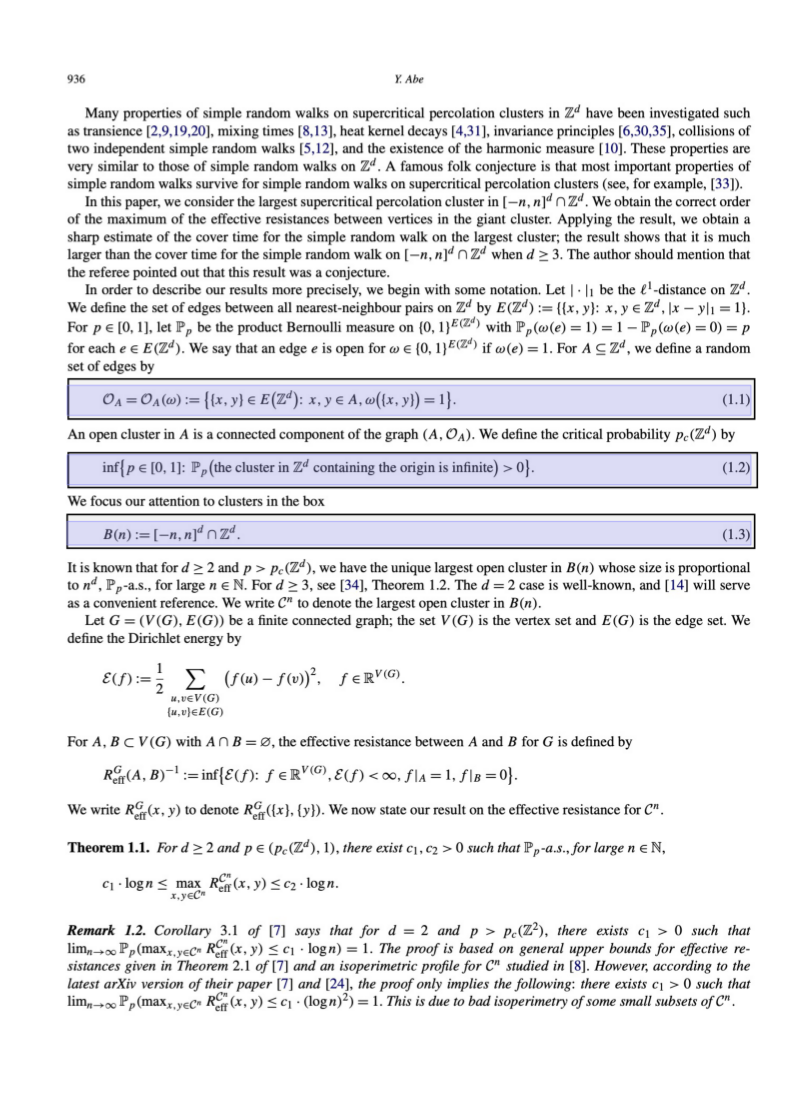

In [ ]:
index = 0

view_model_prediction(model_last,
                      dataset_full, 
                      index,
                      display_dict_last,
                      display_dict_GT,
                      (20,20),
                      thresh = .80,
                      postprocess=True)